This notebook demonstrates how to predict IC50 from BindingDB data using the digital-cell model, as well as giving suggestions for how to enhance the performance of the model beyond that shown here (in the form of TODO statements).

Note: Don't run the first cell more than once at a time - there's a directory called "DeepPurpose" inside the "DeepPurpose" directory, so if the first cell runs twice, all of the paths will be wrong.

In [1]:
import os
os.chdir('./DeepPurpose/')
from datetime import date
import pickle
import torch
from torch.utils import data

from DeepPurpose import utils, dataset, CompoundPred
from DeepPurpose import DTI as models
import digitalcell
import warnings
warnings.filterwarnings("ignore")

# First pass: DeepPurpose model

Only run this first cell if you haven't downloaded BindingDB yet! It's several gigabytes.

In [ ]:
data_path = dataset.download_BindingDB('../data/')


## Data Importing

The entirety of BindingDB is saved as a .tsv file. The function `digitalcell.process_BindingDB_omic` loads it into a Pandas dataframe as well as pulling out drugs, targets, and IC50 values. If the temp_ph setting is True, it only pulls out data that has associated temperature and pH values.

In [2]:
data_path = '../data//BindingDB_All.tsv'
df, X_drugs, X_targets, y = digitalcell.process_BindingDB_omic(path = data_path, temp_ph = True)

Loading Dataset from path...


b'Skipping line 772572: expected 193 fields, saw 205\nSkipping line 772598: expected 193 fields, saw 205\n'
b'Skipping line 805291: expected 193 fields, saw 205\n'
b'Skipping line 827961: expected 193 fields, saw 265\n'
b'Skipping line 1231688: expected 193 fields, saw 241\n'
b'Skipping line 1345591: expected 193 fields, saw 241\nSkipping line 1345592: expected 193 fields, saw 241\nSkipping line 1345593: expected 193 fields, saw 241\nSkipping line 1345594: expected 193 fields, saw 241\nSkipping line 1345595: expected 193 fields, saw 241\nSkipping line 1345596: expected 193 fields, saw 241\nSkipping line 1345597: expected 193 fields, saw 241\nSkipping line 1345598: expected 193 fields, saw 241\nSkipping line 1345599: expected 193 fields, saw 241\n'
b'Skipping line 1358864: expected 193 fields, saw 205\n'
b'Skipping line 1378087: expected 193 fields, saw 241\nSkipping line 1378088: expected 193 fields, saw 241\nSkipping line 1378089: expected 193 fields, saw 241\nSkipping line 1378090: e

Beginning Processing...
There are 93336 drug target pairs.


The cell below just shows what the data looks like.

In [3]:
df.head()

,ID,InChI,SMILES,PubChem_ID,UniProt_ID,Organism,Target Sequence,Kd,IC50,Ki,EC50,kon,koff,pH,Temp,pIC50
180,181,InChI=1/C31H51N5O5/c1-20(2)28(32-22(5)37)30(40...,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,65023.0,NaN,Human immunodeficiency virus 1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,NaN,8.5,NaN,NaN,NaN,NaN,6.0,37.0,8.065502
181,182,InChI=1/C33H55N5O7/c1-7-44-32(42)35-28(22(3)4)...,CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...,461984.0,NaN,Human immunodeficiency virus 1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,NaN,177.0,NaN,NaN,NaN,NaN,6.0,37.0,6.751781
183,184,InChI=1/C35H59N5O9/c1-24(2)30(37-34(44)48-19-1...,COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...,461988.0,NaN,Human immunodeficiency virus 1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,NaN,164.0,NaN,NaN,NaN,NaN,6.0,37.0,6.784891
184,185,InChI=1/C39H67N5O11/c1-28(2)34(41-38(48)54-23-...,COCCOCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccc...,461990.0,NaN,Human immunodeficiency virus 1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,NaN,67.0,NaN,NaN,NaN,NaN,6.0,37.0,7.173277
185,186,InChI=1/C38H51N7O7/c1-24(2)34(43-38(51)52-3)37...,COC(=O)N[C@@H](C(C)C)C(=O)NN(C[C@H](O)[C@H](Cc...,461985.0,NaN,Human immunodeficiency virus 1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,NaN,27.0,NaN,NaN,NaN,NaN,6.0,37.0,7.567031


## Drug and target encoding

DeepPurpose supports [several possible encodings](https://github.com/kexinhuang12345/DeepPurpose#encodings) for drugs and targets. Right now I'm using the Morgan Extended-Connectivity Fingerprints encoding for drugs and the conjoint triad features encoding for targets because they're not computationally intensive.

TODO: compare performance of different drug and target encodings.

In [3]:
drug_encoding, target_encoding = 'Morgan', 'Conjoint_triad'

The following cell splits the data into training, validation, and testing sets. I think these numbers are probably fine, but feel free to adjust them. One thing to note is that for some reason RDKit (the biochemistry library) has trouble translating some of the SMILES data (~500 drugs) into Morgan format. That's only a small fraction of the drugs in the training data, though.

In [4]:
train, val, test = utils.data_process(X_drugs, X_targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2])

Drug Target Interaction Prediction Mode...
in total: 93336 drug-target pairs
encoding drug...
unique drugs: 63535
rdkit not found this smiles for morgan: CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)(F)C[C@H]1C(=O)NCC#N convert to all 0 features
rdkit not found this smiles for morgan: O=C1NC(=O)c2c1c1c3ccccc3n3[Ru](C#[O])[n+]4cccc2c4c13 convert to all 0 features
rdkit not found this smiles for morgan: CN1C(=O)c2c(C1=O)c1cc(F)c[n+]3[Ru](C#[O])n4c5ccc(O)cc5c2c4c13 convert to all 0 features
rdkit not found this smiles for morgan: NOOSc1ccc(CC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles for morgan: NOOSc1ccc(CC[N@@]23CC(=O)O[Re]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles for morgan: CN1C=C[N]2=C1C[N]1(CCc3ccc(SOON)cc3)CC3=[N](C=CN3C)[Re+]21 convert to all 0 features
rdkit not found this smiles for morgan: NOOSc1ccc(NC(=S)NCCCCCCCC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features

rdkit not found this smiles for morgan: Clc1cccc(Cl)c1NC(=O)N1CCN(CC1)c1ccc(cc1)-c1[nH]cnn1CCc1ccccc1 convert to all 0 features
rdkit not found this smiles for morgan: Clc1cccc(Cl)c1NC(=O)N1CCN(CC1)c1ccc(cc1)-c1ncnn1 convert to all 0 features
rdkit not found this smiles for morgan: Cc1ccc(cc1)-c1nc([nH]o1)-c1ccc(cc1)N1CCN(CC1)C(=O)Nc1ccccc1Cl convert to all 0 features
rdkit not found this smiles for morgan: Cn1cc(ccc1C(N)=O)S(=O)(=O)c1ccc(CN\C(Nc2ccncc2)=N/C#N)cc1 convert to all 0 features
rdkit not found this smiles for morgan: Cc1cc(nn1)-c1cc(C(=O)Nc2ccc(F)cn2)c2ncnn2c1 convert to all 0 features
rdkit not found this smiles for morgan: C[N]1=C(OC(=C1)c1cccc(Nc2nccc(n2)-c2cccnc2)c1)N1CCNC(=O)C11CC1 convert to all 0 features
rdkit not found this smiles for morgan: Cc1ccnc(Nc2cccc(C3=C[N](C)=C(O3)N3CCNC(=O)C33CC3)c2C)n1 convert to all 0 features
rdkit not found this smiles for morgan: CN1C=[N](C)C=C1c1ccc(C[C@H](NC(=O)[C@H]2N[C@@H]3CC[C@H]2C3)C#N)c(F)c1 convert to all 0 features
rdkit no

## Model configuration

DeepPurpose's model configuration utility is a wrapper for generating neural networks using PyTorch. The list of options for hyperparameters is [here](https://github.com/kexinhuang12345/DeepPurpose/blob/e169e2f550694145077bb2af95a4031abe400a77/DeepPurpose/utils.py#L486). Several types of model architecture are supported including CNNs, RNNs, MPNNs, MLPs, and transformers. The hyperparameters used below are suggested defaults that aren't too computationally intensive; they produce a 3 layer MPNN. 

TODO: I think there is a lot of potential work to be done on hyperparameter optimization here. 

In [5]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                               target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 3, 
                         LR = 0.001, 
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         mpnn_hidden_size = 128,
                         mpnn_depth = 3
                        )

In [6]:
model = models.model_initialize(**config)

## Model training and loading

Using the hyperparameters above, the model takes about 20 minutes on a GPU (1.5 hours on a laptop CPU) to train on BindingDB. For demo purposes I'm going to load a model I trained earlier, but I used the exact same code as above.

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 49.0665. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 1.36499. Total time 0.00333 hours
Training at Epoch 1 iteration 200 with loss 0.85757. Total time 0.00666 hours
Training at Epoch 1 iteration 300 with loss 0.76675. Total time 0.01 hours
Training at Epoch 1 iteration 400 with loss 1.07368. Total time 0.01333 hours
Training at Epoch 1 iteration 500 with loss 0.93190. Total time 0.01666 hours
Validation at Epoch 1 , MSE: 0.68142 , Pearson Correlation: 0.83315 with p-value: 0.0 , Concordance Index: 0.82024
Training at Epoch 2 iteration 0 with loss 0.59810. Total time 0.01833 hours
Training at Epoch 2 iteration 100 with loss 0.56848. Total time 0.02166 hours
Training at Epoch 2 iteration 200 with loss 0.64867. Total time 0.025 hours
Training at Epoch 2 iteration 300 with loss 0.67891. Total time 0.02833 hours
Training at Epoch 2 iteration 400 with loss 0.54653.

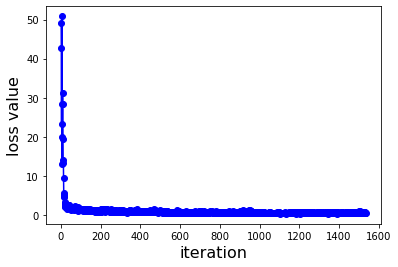

In [7]:
#run this if you want to train a new one
model.train(train, val, test, verbose = True)
today = date.today()
date_time = today.strftime("%m-%d-%y")
model.save_model('../model-'+date_time)

In [5]:
#run this if you want to use my trained one
model = models.model_pretrained(path_dir = '../example_models/model-9-24')

## Model validation

The following code is built in to the DeepPurpose `train` method, I've just pulled it out so I can grab the dataset that was set aside for validation during the data processing step. 

In [6]:
config = model.config
params = {'batch_size': config['batch_size'],
    'shuffle': True,
    'num_workers': config['num_workers'],
    'drop_last': False}

validation_generator = data.DataLoader(utils.data_process_loader(val.index.values, val.Label.values, val, **config), **params)

The available performance metrics are mean squared error, Pearson's R, p-value of Pearson's R, and concordance index.

In [7]:
mse, pearsonr, pvalue, concordance_index, y_pred = models.DBTA.test_(model, validation_generator, model.model, test=True)
print("Pearson's R: ", pearsonr)

Pearson's R:  0.872697291184556


## Model usage

To predict IC50, run data_process to create a dataset consisting of a single drug-target pair, and then run `predict`, which is just a wrapper on `test_`. The output is in pIC50. 

In [8]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
X_pred = utils.data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='no_split')
y_pred = model.predict(X_pred)
print('The predicted score is ' + str(y_pred))

Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [7.395412921905518]


# Second pass: Gradient Boosting with additional information

My main innovation here has been to improve upon DeepPurpose by incorporating additional information such as temperature, pH, and model organism in a gradient boosting model that adjusts the first model's predictions.


## Data importing

By default, calling `digitalcell.feature_select` grabs the temperature and pH values from the dataset, as well as several encodings of the input data. There are a number of supported encodings; the defaults have low overhead and perform well in the classifier. The encodings are input as a list, so you can use as many as you like in combination. Supported encodings are as follows:

Drugs:
* DeepPurpose.smiles2morgan
* DeepPurpose.drug2emb_encoder
* DeepPurpose.calcPubChemFingerAll
* DeepPurpose.smiles2daylight

Targets:
* DeepPurpose.CalculateConjointTriad
* DeepPurpose.protein2emb_encoder
* DeepPurpose.target2quasi


TODO: import support for other datasets (convert to SMILES using https://cactus.nci.nih.gov/chemical/structure)

TODO: The option to include entries that don't have pH and temperature and impute those values should be straightforward to implement

In [9]:
df_data = digitalcell.feature_select(df)

Encoding:  drug2emb_encoder
Elapsed time:  56.15505075454712
Encoding:  smiles2daylight
rdkit not found this smiles: CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)(F)C[C@H]1C(=O)NCC#N convert to all 0 features
rdkit not found this smiles: O=C1NC(=O)c2c1c1c3ccccc3n3[Ru](C#[O])[n+]4cccc2c4c13 convert to all 0 features
rdkit not found this smiles: CN1C(=O)c2c(C1=O)c1cc(F)c[n+]3[Ru](C#[O])n4c5ccc(O)cc5c2c4c13 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(CC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(CC[N@@]23CC(=O)O[Re]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: CN1C=C[N]2=C1C[N]1(CCc3ccc(SOON)cc3)CC3=[N](C=CN3C)[Re+]21 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(NC(=S)NCCCCCCCC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles: NOOSc1ccc(NC(=S)NCCOCCOCC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 c

rdkit not found this smiles: Cc1cc(nn1)-c1cc(C(=O)Nc2ccc(F)cn2)c2ncnn2c1 convert to all 0 features
rdkit not found this smiles: C[N]1=C(OC(=C1)c1cccc(Nc2nccc(n2)-c2cccnc2)c1)N1CCNC(=O)C11CC1 convert to all 0 features
rdkit not found this smiles: Cc1ccnc(Nc2cccc(C3=C[N](C)=C(O3)N3CCNC(=O)C33CC3)c2C)n1 convert to all 0 features
rdkit not found this smiles: CN1C=[N](C)C=C1c1ccc(C[C@H](NC(=O)[C@H]2N[C@@H]3CC[C@H]2C3)C#N)c(F)c1 convert to all 0 features
rdkit not found this smiles: Oc1cnc(Cn2cnc(c(Oc3cc(Cl)cc(c3)C#N)c2=O)C(F)(F)F)c[nH]1 convert to all 0 features
Elapsed time:  331.6637170314789
Encoding:  CalculateConjointTriad
Elapsed time:  333.25377345085144
Encoding:  protein2emb_encoder
Elapsed time:  409.6532506942749


## Getting first pass predictions from Model 1

This cell loads an initial DeepPurpose model and converts the current training data into the format used by said model. Calling `utils.data_process` may not be necessary if you're computing both models at the same time, but if the encodings used in Model 1 differ from those used in Model 2, trying to run the model without doing this might break it.

In [10]:
model = models.model_pretrained(path_dir = '../example_models/model-9-24')

In [11]:
X_pred = utils.data_process(X_drugs, X_targets, y, 
                                model.drug_encoding, model.target_encoding, 
                                split_method='no_split')

Drug Target Interaction Prediction Mode...
in total: 93336 drug-target pairs
encoding drug...
unique drugs: 63535
rdkit not found this smiles for morgan: CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)(F)C[C@H]1C(=O)NCC#N convert to all 0 features
rdkit not found this smiles for morgan: O=C1NC(=O)c2c1c1c3ccccc3n3[Ru](C#[O])[n+]4cccc2c4c13 convert to all 0 features
rdkit not found this smiles for morgan: CN1C(=O)c2c(C1=O)c1cc(F)c[n+]3[Ru](C#[O])n4c5ccc(O)cc5c2c4c13 convert to all 0 features
rdkit not found this smiles for morgan: NOOSc1ccc(CC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles for morgan: NOOSc1ccc(CC[N@@]23CC(=O)O[Re]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features
rdkit not found this smiles for morgan: CN1C=C[N]2=C1C[N]1(CCc3ccc(SOON)cc3)CC3=[N](C=CN3C)[Re+]21 convert to all 0 features
rdkit not found this smiles for morgan: NOOSc1ccc(NC(=S)NCCCCCCCC[N]23CC4=CC=CC=[N]4[Re+]2[N]2=C(C3)C=CC=C2)cc1 convert to all 0 features

rdkit not found this smiles for morgan: Clc1cccc(Cl)c1NC(=O)N1CCN(CC1)c1ccc(cc1)-c1[nH]cnn1CCc1ccccc1 convert to all 0 features
rdkit not found this smiles for morgan: Clc1cccc(Cl)c1NC(=O)N1CCN(CC1)c1ccc(cc1)-c1ncnn1 convert to all 0 features
rdkit not found this smiles for morgan: Cc1ccc(cc1)-c1nc([nH]o1)-c1ccc(cc1)N1CCN(CC1)C(=O)Nc1ccccc1Cl convert to all 0 features
rdkit not found this smiles for morgan: Cn1cc(ccc1C(N)=O)S(=O)(=O)c1ccc(CN\C(Nc2ccncc2)=N/C#N)cc1 convert to all 0 features
rdkit not found this smiles for morgan: Cc1cc(nn1)-c1cc(C(=O)Nc2ccc(F)cn2)c2ncnn2c1 convert to all 0 features
rdkit not found this smiles for morgan: C[N]1=C(OC(=C1)c1cccc(Nc2nccc(n2)-c2cccnc2)c1)N1CCNC(=O)C11CC1 convert to all 0 features
rdkit not found this smiles for morgan: Cc1ccnc(Nc2cccc(C3=C[N](C)=C(O3)N3CCNC(=O)C33CC3)c2C)n1 convert to all 0 features
rdkit not found this smiles for morgan: CN1C=[N](C)C=C1c1ccc(C[C@H](NC(=O)[C@H]2N[C@@H]3CC[C@H]2C3)C#N)c(F)c1 convert to all 0 features
rdkit no

We then use the first model to generate estimates of pIC50 for the whole training dataset.

In [12]:
first_pass = model.predict(X_pred)

predicting...


## Training model 2

This step converts the features generated by the encoding step into vectors to be fed into the model. You can expect this to take over 5 minutes.

TODO: The conversion to vector space here is pretty trivial - you could probably improve the model here by performing PCA or similar for feature extraction instead.

In [13]:
X_train,X_test,y_train,y_test,cat_list = digitalcell.data_process_omic(df_data, first_pass)

Converting features to vectors (this takes a while)


The following two cells generate a gradient boosting model that improves on the performance of model 1 by incorporating additional information and encodings. The model actually consists of 3 estimators, providing an 80 percent lower and upper prediction interval. You can adjust the bounds on the confidence interval when you create the model. Each model takes about 3 or 4 minutes to build.

TODO: There could be substantial improvement on the model hyperparameters here; look at the [sklearn Gradient Boosting Regressor options](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) for suggestions.

In [16]:
model2 = digitalcell.GBoostModel(
    lower_alpha=0.1, upper_alpha=0.9, n_estimators=10, org_list = cat_list, init_model = model)

In [17]:
# Fit and make predictions
model2.fit(X_train, y_train)

Calculating estimates...
Getting lower bound...
Getting upper bound...


We can quickly use this model to make predictions for all of the testing data, which is useful for getting performance metrics.

In [18]:
model2.predictions = model2.predict(X_test)

Be sure to pickle your model to preserve its deliciousness. (This cell just saves the model to a file.)

In [19]:
today = date.today()
date_time = today.strftime("%m-%d-%y")
filename = '../model_'+date_time+'.sav'
pickle.dump(model2, open(filename, 'wb'))

## Usage

For the example usage, I'll be importing two pre-trained models, a DeepPurpose one and a Gradient Boosted one built on top of it. I saved the typelist seperately for this model, but if you make a new model, it should be automatically stored in model2.typelist.

In [14]:
model = models.model_pretrained(path_dir = '../example_models/model-9-24')
model2 = pickle.load( open( "../example_models/model_10_12.sav", "rb" ) )
model2.typelist = pickle.load(open('../example_models/model_10_12_typelist.sav',"rb"))

Enter the drug in SMILES format and the target in AAC format here.

In [15]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']

This is where you can include the temperature and pH information if you have them; it also works if you leave either one out. The values shown below are the defaults.

In [20]:
pred = digitalcell.model_usage(model, model2, X_drug, X_target, temp = 35, pH = 7)

Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
Encoding:  drug2emb_encoder
Elapsed time:  0.003998517990112305
Encoding:  smiles2daylight
Elapsed time:  0.011998891830444336
Encoding:  CalculateConjointTriad
Elapsed time:  0.01799798011779785
Encoding:  protein2emb_encoder
Elapsed time:  0.023006916046142578
Estimated pIC50:  [7.0326146]
Lower bound:  [5.75294071]
Upper bound:  [8.18879894]


Here you can compare the performance of my best DeepPurpose model (`model`) with my best gradient boosting model (`model2`). Unfortunately, my second model isn't strictly better, but hopefully I've given you the infrastructure to iterate on my model and improve it.

predicting...
Average error:  0.5759653421717266
Fraction correct within one order of magnitude:  0.8374796434394713
Fraction correct within two orders of magnitude:  0.9815505271289866
Pearson's R =  (0.8725064130131689, 0.0)


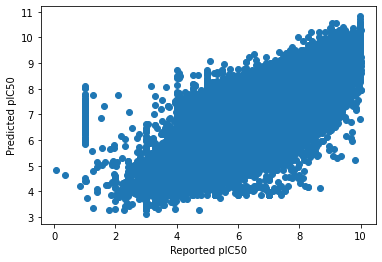

(None, None)

In [17]:
digitalcell.model_metrics(model, X_pred,y)

Average error:  0.6881187290076366
Fraction correct within one order of magnitude:  0.7546889901452655
Fraction correct within two orders of magnitude:  0.9839461693337167
Pearson's R =  (0.8782765917728603, 0.0)


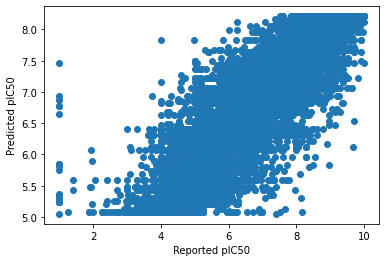

In [18]:
importances, type_importance = digitalcell.model_metrics(model2, X_test, y_test, model2.typelist)

The advantage of the Gradient Boosting model is it can also give you feature importances; the following chart tells you what information the model is weighting heavily. "estimate" refers to the estimate from Model 1.

In [19]:
type_importance

,importance
Type,
estimate,0.995
protein2emb_encoder,0.005
CalculateConjointTriad,0.000
Temp,0.000
drug2emb_encoder,0.000
organism,0.000
pH,0.000
smiles2daylight,0.000
